## VAE 
This notebook shows how to construct and train the Variational AutoEncoder used in the blog tutorial to model the images of the galaxies.   

The VAE was adapted from
https://github.com/atinghosh/VAE-pytorch/blob/master/VAE_facebook.py  by Atin Ghosh

In [2]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from tqdm import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import torch



In [3]:
import cv2
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [5]:
device = get_default_device()
#device = 'cpu'
CUDA = True
SEED = 1
BATCH_SIZE = 16
batch_size = BATCH_SIZE

In [6]:
image_size = 128
image_size = 128


In [7]:
DATA_DIR = "C:/Users/denni/OneDrive/Docs9/gan/galaxies3"
#A copy of the data file can be found on the github page.

In [8]:
dataset = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size), #sqaure from rectangle images
    T.ToTensor()]))


train_dl = DataLoader(dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)
train_loader = DeviceDataLoader(train_dl, device)

In [9]:
len(train_dl.dataset)

94

In [10]:
for real_images, _ in tqdm(train_dl):
    break

  0%|                                                                                            | 0/6 [00:01<?, ?it/s]


torch.Size([16, 3, 128, 128])
torch.Size([128, 128, 3])


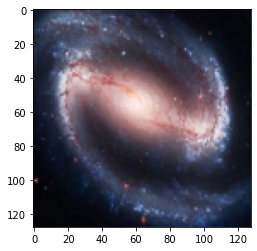

In [11]:
image, label = dataset[0]
#real_images = image.permute((1,2,0))
plt.imshow(image.permute((1,2,0)))
print(real_images.shape)
print(image.permute((1,2,0)).shape)

In [12]:
def showbatch(dl):    
    plt.figure(figsize=(8, 16))
    for images, zz in dl:
        print(images.shape)
        for j in range(4):
            for i in range(4):
                plt.subplot(8, 4, 4*j+i+1)
                plt.imshow(images[4*j+i].cpu().permute(1, 2, 0))#, vmin=0, vmax=1, cmap="gray")
                #plt.title("Test input")
                #plt.colorbar()
        break
        plt.tight_layout()

torch.Size([16, 3, 128, 128])


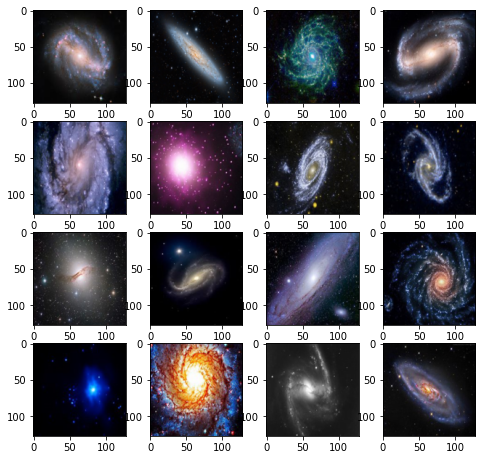

In [13]:
showbatch(train_dl)

In [14]:
import torch.nn as nn
import torch
from torch import nn


In [15]:
latent_size = 64
#device = 'cpu'
fixed_latent = torch.randn(16, latent_size, 1, 1, device=device)
fixed_latent2 = torch.randn(16, latent_size, 1, 1, device=device)

In [16]:
ZDIMS = 20
HIDDEN = 500
import os
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # ENCODER
        # 28 x 28 pixels = 784 input pixels, 400 outputs
        self.fc1 = nn.Linear(49152, HIDDEN)
        # rectified linear unit layer from 400 to 400
        # max(0, x)
        self.relu = nn.ReLU()
        self.fc21 = nn.Linear( HIDDEN, ZDIMS)  # mu layer
        self.fc22 = nn.Linear( HIDDEN, ZDIMS)  # logvariance layer
        # this last layer bottlenecks through ZDIMS connections

        # DECODER
        # from bottleneck to hidden 400
        self.fc3 = nn.Linear(ZDIMS,  HIDDEN)
        # from hidden 400 to 784 outputs
        self.fc4 = nn.Linear( HIDDEN, 49152)
        self.sigmoid = nn.Sigmoid()

    def encode(self, x: Variable) -> (Variable, Variable):
        """Input vector x -> fully connected 1 -> ReLU -> (fully connected
        21, fully connected 22)

        Parameters
        ----------
        x : [16, 49152] matrix; 16 images of 128x128 pixels each

        Returns
        -------

        (mu, logvar) : ZDIMS mean units one for each latent dimension, ZDIMS
            variance units one for each latent dimension

        """

        # h1 is [128, 400]
        h1 = self.relu(self.fc1(x))  # type: Variable
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu: Variable, logvar: Variable) -> Variable:
        """THE REPARAMETERIZATION IDEA:

        For each training sample (we get 128 batched at a time)

        - take the current learned mu, stddev for each of the ZDIMS
          dimensions and draw a random sample from that distribution
        - the whole network is trained so that these randomly drawn
          samples decode to output that looks like the input
        - which will mean that the std, mu will be learned
          *distributions* that correctly encode the inputs
        - due to the additional KLD term (see loss_function() below)
          the distribution will tend to unit Gaussians

        Parameters
        ----------
        mu : [16, ZDIMS] mean matrix
        logvar : [16, ZDIMS] variance matrix

        Returns
        -------

        During training random sample from the learned ZDIMS-dimensional
        normal distribution; during inference its mean.

        """

        if self.training:
            # multiply log variance with 0.5, then in-place exponent
            # yielding the standard deviation
            std = logvar.mul(0.5).exp_()  # type: Variable
            # - std.data is the [16,ZDIMS] tensor that is wrapped by std
            # - so eps is [16,ZDIMS] with all elements drawn from a mean 0
            #   and stddev 1 normal distribution that is 128 samples
            #   of random ZDIMS-float vectors
            eps = Variable(std.data.new(std.size()).normal_())
            # - sample from a normal distribution with standard
            #   deviation = std and mean = mu by multiplying mean 0
            #   stddev 1 sample with desired std and mu, see
            #   https://stats.stackexchange.com/a/16338
            # - so we have 16 sets (the batch) of random ZDIMS-float
            #   vectors sampled from normal distribution with learned
            #   std and mu for the current input
            return eps.mul(std).add_(mu)

        else:
            # During inference, we simply spit out the mean of the
            # learned distribution for the current input.  We could
            # use a random sample from the distribution, but mu of
            # course has the highest probability.
            return mu

    def decode(self, z: Variable) -> Variable:
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x: Variable) -> (Variable, Variable, Variable):
        mu, logvar = self.encode(x.view(-1, 49152))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [18]:
model = VAE()
if CUDA:
    model.cuda()

In [19]:
def loss_function(recon_x, x, mu, logvar) -> Variable:
    # how well do input x and output recon_x agree?
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 49152))

    # KLD is Kullback–Leibler divergence -- how much does one learned
    # distribution deviate from another, in this specific case the
    # learned distribution from the unit Gaussian

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # - D_{KL} = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # note the negative D_{KL} in appendix B of the paper
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Normalise by same number of elements as in reconstruction
    KLD /= BATCH_SIZE * 49152

    # BCE tries to make our reconstruction as accurate as possible
    # KLD tries to push the distributions as close as possible to unit Gaussian
    return BCE + KLD

# Dr Diederik Kingma: as if VAEs weren't enough, he also gave us Adam!
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [35]:
LOG_INTERVAL = 10

def train(epoch):
    # toggle model to train mode
    model.train()
    train_loss = 0
    # in the case of MNIST, len(train_loader.dataset) is 60000
    # each `data` is of BATCH_SIZE samples and has shape [128, 1, 28, 28]
    i = 0
    for i in range(epoch):
        for batch_idx, (data, _) in enumerate(train_dl):
            data = Variable(data)
            if CUDA:
                data = data.cuda()
            optimizer.zero_grad()

            # push whole batch of data through VAE.forward() to get recon_loss
            #print(data.shape)
            recon_batch, mu, logvar = model(data)

            # calculate scalar loss
            loss = loss_function(recon_batch, data, mu, logvar)
            # calculate the gradient of the loss w.r.t. the graph leaves
            # i.e. input variables -- by the power of pytorch!
            loss.backward()
            train_loss += loss.item() #loss.data[0]
            optimizer.step()
        if i % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                i, batch_idx * len(data), len(train_dl.dataset),
                100. * batch_idx / len(train_dl),
                loss.item()/ len(data)))
          

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_dl.dataset)))


In [36]:

train(300)

Train Epoch: 0 [70/94 (83%)]	Loss: 0.039960
Train Epoch: 10 [70/94 (83%)]	Loss: 0.029769
Train Epoch: 20 [70/94 (83%)]	Loss: 0.027165
Train Epoch: 30 [70/94 (83%)]	Loss: 0.029032
Train Epoch: 40 [70/94 (83%)]	Loss: 0.027228
Train Epoch: 50 [70/94 (83%)]	Loss: 0.027194
Train Epoch: 60 [70/94 (83%)]	Loss: 0.024552
Train Epoch: 70 [70/94 (83%)]	Loss: 0.028331
Train Epoch: 80 [70/94 (83%)]	Loss: 0.026680
Train Epoch: 90 [70/94 (83%)]	Loss: 0.028175
Train Epoch: 100 [70/94 (83%)]	Loss: 0.026270
Train Epoch: 110 [70/94 (83%)]	Loss: 0.025949
Train Epoch: 120 [70/94 (83%)]	Loss: 0.027412
Train Epoch: 130 [70/94 (83%)]	Loss: 0.026388
Train Epoch: 140 [70/94 (83%)]	Loss: 0.025891
Train Epoch: 150 [70/94 (83%)]	Loss: 0.022978
Train Epoch: 160 [70/94 (83%)]	Loss: 0.028499
Train Epoch: 170 [70/94 (83%)]	Loss: 0.026015
Train Epoch: 180 [70/94 (83%)]	Loss: 0.028797
Train Epoch: 190 [70/94 (83%)]	Loss: 0.026194
Train Epoch: 200 [70/94 (83%)]	Loss: 0.026603
Train Epoch: 210 [70/94 (83%)]	Loss: 0.024409

In [37]:
model.training

True

In [38]:
model_file = "C:/Users/denni/OneDrive/Docs15/galaxy_variational128_model"
torch.save(model.state_dict(), model_file)

In [17]:
def load_model():
    model_file = "C:/Users/denni/OneDrive/Docs15/galaxy_variational128_model"
    model = VAE()
    model.load_state_dict(torch.load(model_file))
    model.eval()
    return model

In [25]:
model = load_model()
model.cuda()
model.eval()

VAE(
  (fc1): Linear(in_features=49152, out_features=500, bias=True)
  (relu): ReLU()
  (fc21): Linear(in_features=500, out_features=20, bias=True)
  (fc22): Linear(in_features=500, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=500, bias=True)
  (fc4): Linear(in_features=500, out_features=49152, bias=True)
  (sigmoid): Sigmoid()
)

In [26]:
def getreco(data):
    model.eval()
    return model(data)

In [27]:
for real_images, _ in tqdm(train_loader):
    break

  0%|                                                                                            | 0/6 [00:01<?, ?it/s]


In [28]:
sample_dir = "C:/Users/denni/OneDrive/Docs15/gan_samples"

torch.Size([16, 3, 128, 128])


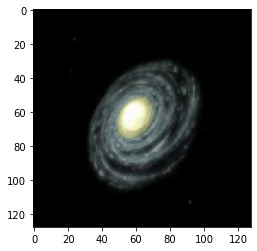

In [29]:
plt.imshow(real_images[5].cpu().permute((1,2,0)))
print(real_images.shape)

In [30]:
reco, mu, logvar = getreco(real_images)
print(reco.shape)

torch.Size([16, 49152])


In [31]:
reco = reco.reshape(16, 3,128,128)
reco.shape

torch.Size([16, 3, 128, 128])

In [32]:
#print('mu=', mu, ' logvar=', logvar)

torch.Size([16, 3, 128, 128])


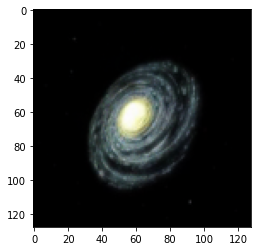

In [33]:
x = reco[5].cpu().permute(1,2,0)
plt.imshow(x.detach().numpy())
print(real_images.shape)

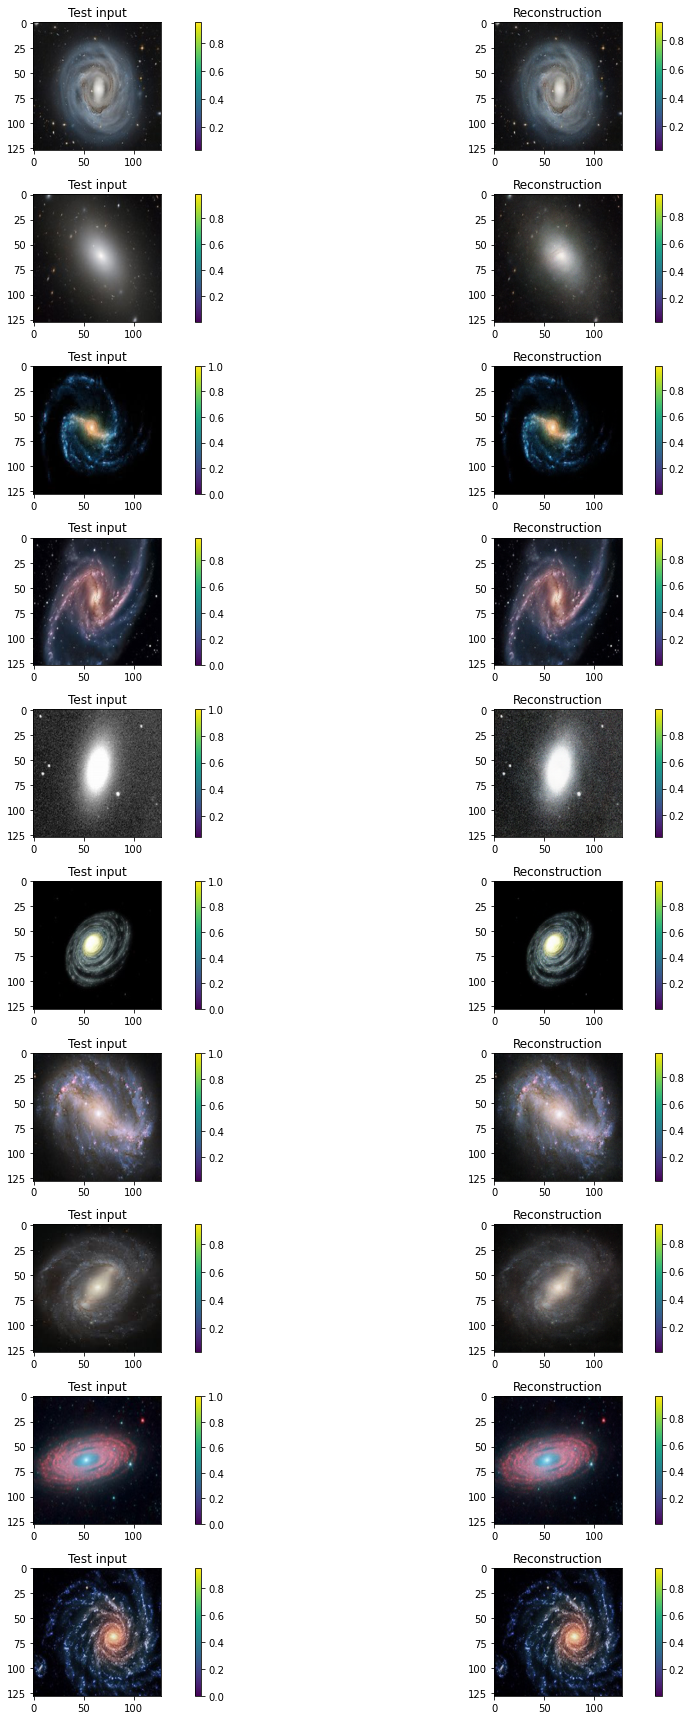

In [34]:
plt.figure(figsize=(16, 24))
for i in range(10):
    plt.subplot(10, 2, 2*i + 1)
    plt.imshow(real_images[i].cpu().permute((1,2,0)))#, vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(10, 2, 2*i + 2)
    plt.imshow(reco[i].cpu().reshape(3,128,128).permute(1,2,0).detach().numpy())#, vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

## showing a path in the latent space from one galxy to another.

In [50]:
z = model.reparameterize(mu, logvar)
x = model.decode(z)

In [51]:
z.shape

torch.Size([16, 20])

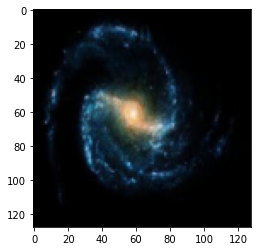

In [52]:
x = x.reshape(16, 3,128,128)
xx = x[2].cpu().permute(1,2,0)
plt.imshow(xx.detach().numpy())

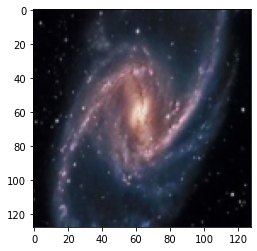

In [58]:
x = model.decode(z[6])
x =x.reshape(3,128,128).cpu().permute(1,2,0)
plt.imshow(x.detach().numpy())

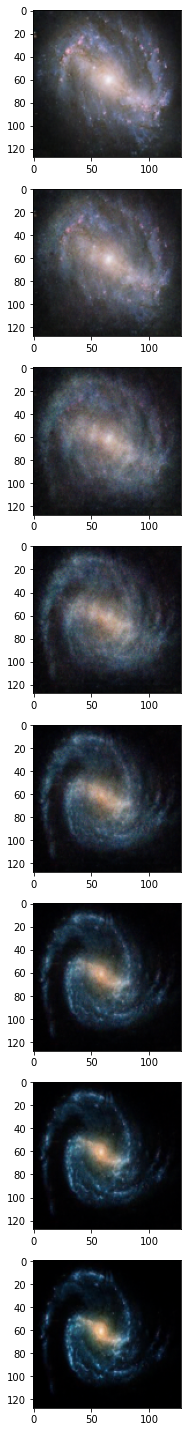

In [53]:
z = mu
zb = z[2]
ze = z[6]

plt.figure(figsize=(16, 20))
for i in range(8):
    plt.subplot(8, 1, i + 1)
    z = i/8.0*zb + (7.0-i)/8*ze
    x = model.decode(z)
    x =x.reshape(3,128,128).cpu().permute(1,2,0)
    plt.imshow(x.detach().numpy())
plt.tight_layout()

In [54]:
print(zb.norm(), ze.norm(), (ze-zb).norm())

tensor(11.6984, device='cuda:0', grad_fn=<CopyBackwards>) tensor(7.4975, device='cuda:0', grad_fn=<CopyBackwards>) tensor(14.6100, device='cuda:0', grad_fn=<CopyBackwards>)


In [21]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(fake_images, sample_dir+'/'+fake_fname, nrow=4)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(16,16))
        ax.set_xticks([]); ax.set_yticks([])
        #ax.imshow(make_grid(denorm(fake_images.cpu().detach()), nrow=4).permute(1, 2, 0))
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=4).permute(1, 2, 0))